7
(927, 50, 37)
(927,)
Epoch 1/100
29/29 [==============================] - 1s 13ms/step - loss: 10.2949 - accuracy: 0.3981 - val_loss: 8.2834 - val_accuracy: 0.5194
Epoch 2/100
29/29 [==============================] - 0s 7ms/step - loss: 8.8746 - accuracy: 0.4110 - val_loss: 7.9894 - val_accuracy: 0.5194
Epoch 3/100
29/29 [==============================] - 0s 7ms/step - loss: 8.6921 - accuracy: 0.4110 - val_loss: 7.7837 - val_accuracy: 0.5194
Epoch 4/100
29/29 [==============================] - 0s 7ms/step - loss: 8.5218 - accuracy: 0.4229 - val_loss: 7.4950 - val_accuracy: 0.5194
Epoch 5/100
29/29 [==============================] - 0s 7ms/step - loss: 8.3114 - accuracy: 0.4380 - val_loss: 7.2386 - val_accuracy: 0.5659
Epoch 6/100
29/29 [==============================] - 0s 7ms/step - loss: 8.0260 - accuracy: 0.4606 - val_loss: 6.8727 - val_accuracy: 0.5504
Epoch 7/100
29/29 [==============================] - 0s 7ms/step - loss: 7.7240 - accuracy: 0.4844 - val_loss: 6.7844 - val_accur

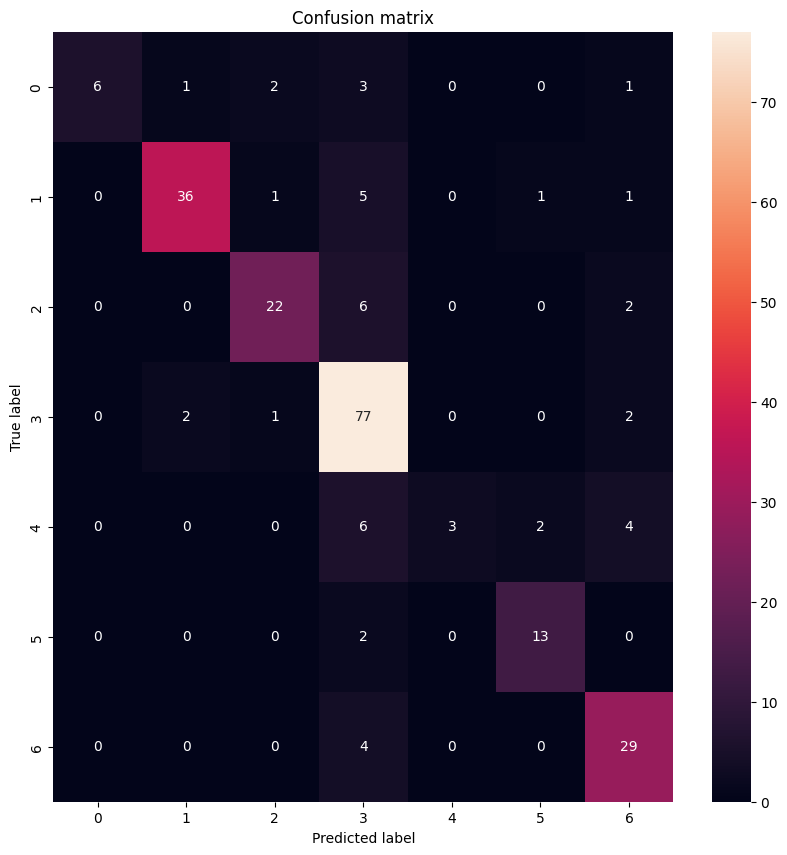

In [5]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split

from keras.models import Sequential
# include convolutional layers
from keras.layers import Conv2D
# Pooling layers
from keras.layers import MaxPooling2D
# flatten layers into single vector
from keras.layers import Flatten
from keras.layers import Dense

# Load LFW dataset
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
x_data = lfw_people.images
y_data = lfw_people.target

# Split the dataset into training and testing sets
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Determine the number of classes
num_classes = len(set(y_train))
print(num_classes)

def cosine_loss(y_true, y_pred):
    scale = 30.0
    margin = 0.35
    t=0.8

    # Convert y_true to float32
    y_true = tf.cast(y_true, tf.float32)

    # L2 normalize embeddings
    costheta = K.l2_normalize(y_pred, axis=1)
    theta=tf.acos(costheta)
    # print(y_pred.shape)
    m_theta=theta+margin*y_true
    m_costheta=tf.cos(m_theta)
    temp=tf.reduce_sum((y_true*m_costheta),axis=1)
    extended_tensor = tf.expand_dims(temp, axis=1)
    # Duplicate the original data 7 times
    value = tf.concat([extended_tensor] * 7, axis=1)
    # print(value.shape)

    condition=m_costheta>value
    f=tf.where(condition,t*(m_costheta),m_costheta)
    # print(f.shape)
    y_pred=scale*f

    # Compute the final Cosine loss
    loss = K.categorical_crossentropy(y_true, y_pred, from_logits=True)
    # Combine the loss with the angular margin penalty
    cos_loss = K.mean(loss , axis=-1)

    return cos_loss


# def cosine_loss(y_true, y_pred):
#     scale = 30.0
#     margin = 0.35


#     # Convert y_true to float32
#     y_true = tf.cast(y_true, tf.float32)

#     # L2 normalize embeddings
#     costheta = K.l2_normalize(y_pred, axis=1)
#     theta=tf.acos(costheta)

#     m_theta=theta+margin*y_true
#     m_costheta=tf.cos(m_theta)

#     y_pred=scale*m_costheta

#     # Compute the final Cosine loss
#     loss = K.categorical_crossentropy(y_true, y_pred, from_logits=True)
#     # Combine the loss with the angular margin penalty
#     cos_loss = K.mean(loss , axis=-1)

#     return cos_loss


print(x_train.shape)
print(y_train.shape)
# Define model
inputs = Input(shape=(x_train.shape[1], x_train.shape[2],1))

x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(inputs)
x = Dense(128, activation='relu')(x)
outputs = Dense(num_classes, activation=None)(x)  # No activation on final dense layer
outputs = Lambda(lambda x: K.l2_normalize(x, axis=1))(outputs)  # L2 normalize embeddings

model = Model(inputs, outputs)

# Compile model
model.compile(optimizer='adam', loss=cosine_loss, metrics=['accuracy'])


# Preprocess the data and scale pixel values to the range [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0

# Convert integer labels to one-hot encoded labels
y_train = tf.one_hot(y_train, depth=num_classes)
y_test = tf.one_hot(y_test, depth=num_classes)
y_val = tf.one_hot(y_val, depth=num_classes)



# Train model
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100)

# Predict on test data
y_pred = model.predict(x_test)

# Convert predictions to label index
y_pred_argmax = tf.argmax(y_pred, axis=1)
y_test_argmax = tf.argmax(y_test, axis=1)

# Generate a classification report
report = classification_report(y_test_argmax, y_pred_argmax)

# Print the classification report
print("Classification Report:\n", report)

# Compute confusion matrix
cm = confusion_matrix(y_test_argmax, y_pred_argmax)

# Plot confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()
